***
# Beginner's Workshop on Machine Learning: _Kernels_
***

This tutorial is basically split into four parts:
1. Kernel Methods
2. Standard Kernels
3. Learning Kernels
4. Approximating Kernels

Throughout all parts, four distinct datasets can be used to 
examine various settings. Descriptions of each of the datasets
can be found on the respective website:

1. MNIST (http://yann.lecun.com/exdb/mnist/)
2. EMNIST (https://www.nist.gov/itl/iad/image-group/emnist-dataset)
3. Fashion-MNIST (https://github.com/zalandoresearch/fashion-mnist)
4. Cifar10 (https://www.cs.toronto.edu/~kriz/cifar.html)


***

In [1]:
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.metrics as metrics
import sklearn.kernel_approximation as approx
import numpy as np
import time
%matplotlib inline
data_dir = "/home/space/datasets"

## Datasets

Functions for loading the various datasets. E.g. MNIST: This well-known dataset consists of hand-written digits and hence, splits into 10 classes ('0'-'9'). Moreover, train- and testsets are separated and contain 60.000 (10.000) examples in total. For more information about the datasets, follow one of the links above.

In [2]:
def load_mnist_dataset():
    import torchvision.datasets as datasets

    mnist_train = datasets.MNIST(root=data_dir.format("mnist"), train=True, download=True, transform=None)
    mnist_test = datasets.MNIST(root=data_dir.format("mnist"), train=False, download=True, transform=None)
    test_labels = np.array([mnist_test[i][1] for i in range(len(mnist_test))], dtype=np.int)
    train_labels = np.array([mnist_train[i][1] for i in range(len(mnist_train))], dtype=np.int)
    test = np.array([np.asarray(mnist_test[i][0]).reshape(28*28) for i in range(len(mnist_test))], dtype=np.float)
    train = np.array([np.asarray(mnist_train[i][0]).reshape(28*28) for i in range(len(mnist_train))], dtype=np.float)
    train /= 255.  # normalize data to be in range [0,1]
    test /= 255.
    return train, train_labels, test, test_labels, [28, 28]

In [3]:
def load_fashion_mnist_dataset():
    import torchvision.datasets as datasets

    mnist_train = datasets.FashionMNIST(root=data_dir.format("fashion_mnist"), train=True, download=True, transform=None)
    mnist_test = datasets.FashionMNIST(root=data_dir.format("fashion_mnist"), train=False, download=True, transform=None)
    test_labels = np.array([mnist_test[i][1] for i in range(len(mnist_test))], dtype=np.int)
    train_labels = np.array([mnist_train[i][1] for i in range(len(mnist_train))], dtype=np.int)
    test = np.array([np.asarray(mnist_test[i][0]).reshape(28*28) for i in range(len(mnist_test))], dtype=np.float)
    train = np.array([np.asarray(mnist_train[i][0]).reshape(28*28) for i in range(len(mnist_train))], dtype=np.float)
    train /= 255.  # normalize data to be in range [0,1]
    test /= 255.
    return train, train_labels, test, test_labels, [28, 28]

In [4]:
def load_emnist_dataset():
    import torchvision.datasets as datasets

    mnist_train = datasets.EMNIST(root=data_dir.format("emnist"), split='balanced', train=True, download=True, transform=None)
    mnist_test = datasets.EMNIST(root=data_dir.format("emnist"), split='balanced', train=False, download=True, transform=None)
    test_labels = np.array([mnist_test[i][1] for i in range(len(mnist_test))], dtype=np.int)
    train_labels = np.array([mnist_train[i][1] for i in range(len(mnist_train))], dtype=np.int)
    test = np.array([np.asarray(mnist_test[i][0]).reshape(28*28) for i in range(len(mnist_test))], dtype=np.float)
    train = np.array([np.asarray(mnist_train[i][0]).reshape(28*28) for i in range(len(mnist_train))], dtype=np.float)
    train /= 255.  # normalize data to be in range [0,1]
    test /= 255.
    return train, train_labels, test, test_labels, [28, 28]

In [5]:
def load_cifar10_dataset():
    import torchvision.datasets as datasets

    cifar_train = datasets.CIFAR10(root=data_dir.format("cifar10"), train=True, download=True, transform=None)
    cifar_test = datasets.CIFAR10(root=data_dir.format("cifar10"), train=False, download=True, transform=None)
    test_labels = np.array([cifar_test[i][1] for i in range(len(cifar_test))], dtype=np.int)
    train_labels = np.array([cifar_train[i][1] for i in range(len(cifar_train))], dtype=np.int)
    test = np.array([np.asarray(cifar_test[i][0].convert('F')).reshape(32*32) for i in range(len(cifar_test))], dtype=np.float)
    train = np.array([np.asarray(cifar_train[i][0].convert('F')).reshape(32*32) for i in range(len(cifar_train))], dtype=np.float)
    train /= 255.  # normalize data to be in range [0,1]
    test /= 255.
    return train, train_labels, test, test_labels, [32, 32]

***

## Part I: Investigate Dataset using Outlier Detection

There are two tasks:

1. Implement a version of the rbf kernel with $\exp(\frac{-\|x-y\|^2}{param})$
2. Implement the one-class SVM for the special case of $\nu = 1$

In [6]:
train, train_labels, test, test_labels, im_size = load_mnist_dataset()
#train, train_labels, test, test_labels, im_size = load_fashion_mnist_dataset()
# train, train_labels, test, test_labels, im_size = load_emnist_dataset()
# train, train_labels, test, test_labels, im_size = load_cifar10_dataset()
print('Train dataset size: ', train.shape)
print('Test dataset size: ', test.shape)
print('Num classes: ', np.unique(train_labels).size)
print('Image size: ', im_size)

Train dataset size:  (60000, 784)
Test dataset size:  (10000, 784)
Num classes:  10
Image size:  [28, 28]


In [7]:
def calc_rbf_kernel(X, Y=None, param=1.):
    if Y is None:
        Y = X
    # YOUR CODE HERE
    distance = (X**2).sum(axis=1)[:, None] - 2 * X.dot(Y.T) + ((Y**2).sum(axis=1)[None, :])
    #distance = np.linalg.norm(X-Y)**2
    #sigma = param/X.shape[1]
    return np.exp(-distance/(param))
    # END

In [21]:
def one_class_svm_nu_one(kernel):
    # YOUR CODE HERE

    w = np.mean(kernel, axis = 0)
    #y = w @ kernel.T
    return w#y
    # END

In [22]:
# 1. crude check of your kernel implementation
K = calc_rbf_kernel(train[:100, :], param=10.)

# 1.a. check if eigenvalues are all non-negative (=positive semi-definite matrix)
w, _ = np.linalg.eig(K)
assert(np.all(w) >= 0.0)

# 1.b. check if there are significant abberations from the sklearn implementation
K_check = metrics.pairwise.rbf_kernel(train[:100, :], gamma=1./10.)
#print(K_check)
assert(np.max(np.abs(K-K_check)) < 1e-03)

# 2. crude check of your special case one-class SVM implementation
outlier_scores = one_class_svm_nu_one(0.1*np.random.randn(4,4) + np.eye(4))
assert(outlier_scores.size == 4)
assert(outlier_scores.shape[0] == 4)

(200, 6742)
(6742,)
Memory footprint of your RBF matrix (200x6742 elements): 10MB


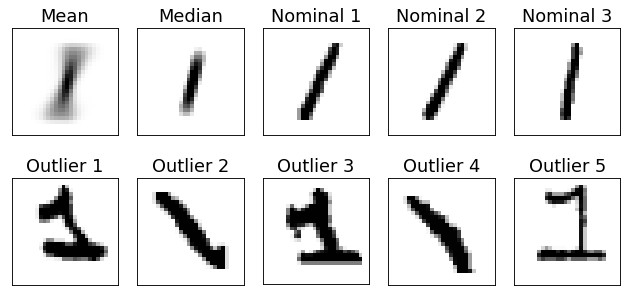

In [23]:
CLASS = 1
NUM_TRAIN_SAMPLES = 200
RBF_PARAM = 1.

class_inds = np.where(train_labels == CLASS)[0]
train_inds = np.random.permutation(class_inds.size)[:NUM_TRAIN_SAMPLES]

fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 5, 1)
plt.title('Mean', fontsize=16)
class_mean = np.mean(train[class_inds, :], axis=0)
plt.imshow(class_mean.reshape(im_size[0], im_size[1]), cmap='binary')
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

plt.subplot(2, 5, 2)
plt.title('Median', fontsize=16)
class_median = np.median(train[class_inds, :], axis=0)
plt.imshow(class_median.reshape(im_size[0], im_size[1]), cmap='binary')
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

kernel = calc_rbf_kernel(train[class_inds[train_inds], :], train[class_inds, :], param=RBF_PARAM)
print(kernel.shape)
outlier_scores = one_class_svm_nu_one(kernel)
outlier_ranking = np.argsort(-outlier_scores)
print(outlier_scores.shape)
print('Memory footprint of your RBF matrix ({0}x{1} elements): {2}MB'.format(
    kernel.shape[0], kernel.shape[1], np.int(kernel.size*kernel.itemsize / (1024.*1024.))))

for i in range(3):
    plt.subplot(2, 5, 3+i)
    plt.title('Nominal {0}'.format(i+1), fontsize=16)
    plt.imshow(train[class_inds[outlier_ranking[i]], :].reshape(im_size[0], im_size[1]), cmap='binary')
    plt.xticks([], [], fontsize=14)
    plt.yticks([], [], fontsize=14)

for i in range(5):
    plt.subplot(2, 5, 6+i)
    plt.title('Outlier {0}'.format(i+1), fontsize=16)
    plt.imshow(train[class_inds[outlier_ranking[-(i+1)]], :].reshape(im_size[0], im_size[1]), cmap='binary')
    plt.xticks([], [], fontsize=14)
    plt.yticks([], [], fontsize=14)

fig.tight_layout()

Text(0, 0.5, 'outlier score')

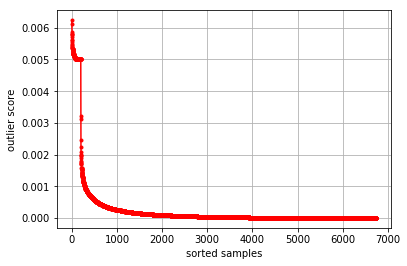

In [24]:
plt.plot(np.arange(outlier_ranking.size), outlier_scores[outlier_ranking], '.-r')
plt.grid(True)
plt.xlabel('sorted samples')
plt.ylabel('outlier score')

***

## Part II: Image Classification using Histogram Intersection Kernels

In [18]:
# train, train_labels, test, test_labels, im_size = load_mnist_dataset()
# train, train_labels, test, test_labels, im_size = load_fashion_mnist_dataset()
# train, train_labels, test, test_labels, im_size = load_emnist_dataset()
train, train_labels, test, test_labels, im_size = load_cifar10_dataset()
print('Train dataset size: ', train.shape)
print('Test dataset size: ', test.shape)
print('Num classes: ', np.unique(train_labels).size)
print('Image size: ', im_size)

Files already downloaded and verified
Files already downloaded and verified
Train dataset size:  (50000, 1024)
Test dataset size:  (10000, 1024)
Num classes:  10
Image size:  [32, 32]


In [41]:
def calc_hist_intersect_kernel(X, Y=None):
    if Y is None:
        Y = X
    K = np.zeros((X.shape[0],Y.shape[0]))
    #distance = np.abs(X[:,0,None] - Y[:,0]) + np.abs(X[:,1,None] - Y[:,1])
    #print((X[:,0,None] - Y[:,0]).shape)
    #print((X[:,1,None] - Y[:,1]).shape)
    #print(distance.shape)
    #print(X[:,0,None].shape)
    #print(Y[:,0].shape)
    #print((X[:,0,None] + Y[:,0]).shape)
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            K[i,j] = 0.5 * (X[i] + Y[j] - (np.abs(X[i] - Y[j]))).sum()
    
    return K

K = calc_hist_intersect_kernel(train[:100, :], train[:10, :])
assert(K.shape[0] == 100 and K.shape[1] == 10)

In [42]:
def calc_histogram_features(X, bins=10, normalize=False):
    num_samples, num_features = X.shape
    # YOUR CODE HERE
    hist_list = []
    for i in range(num_samples):
        hist, _ = np.histogram(X,bins,normed=normalize)
        hist_list.append(hist)
    return np.array(hist_list)
    # END
    

There are 199 positive samples and 201 negative samples in the dataset.


/home/bewoadmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


AUC RBF kernel:  0.8355555555555556
AUC histogram intersection kernel:  0.5


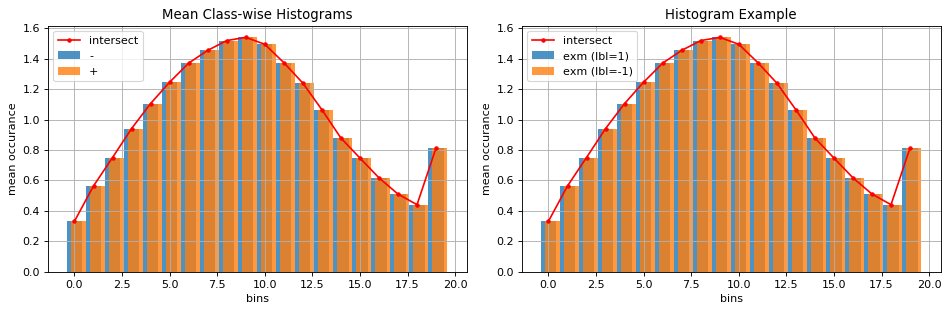

In [43]:
POS_CLASS = 2  # 6: Shirt
NEG_CLASS = 9  # 0: T-Shirt/Top

BINS = 20
NORMALIZE = True

NUM_TRAIN_SAMPLES = 200
NUM_TEST_SAMPLES = 200

pos_class_inds = np.where(train_labels == POS_CLASS)[0]
neg_class_inds = np.where(train_labels == NEG_CLASS)[0]
class_inds = np.concatenate((pos_class_inds, neg_class_inds))
lbl = train_labels[class_inds]
lbl[lbl == NEG_CLASS] = -1
lbl[lbl == POS_CLASS] = +1

# split in train and test chunks
rand_inds = np.random.permutation(class_inds.size)
train_inds = rand_inds[:NUM_TRAIN_SAMPLES]
test_inds = rand_inds[NUM_TRAIN_SAMPLES:]
test_inds = test_inds[:NUM_TEST_SAMPLES]
print('There are {0} positive samples and {1} negative samples in the dataset.'.format(
    np.sum(lbl[rand_inds[:NUM_TRAIN_SAMPLES+NUM_TEST_SAMPLES]] == +1), 
    np.sum(lbl[rand_inds[:NUM_TRAIN_SAMPLES+NUM_TEST_SAMPLES]] == -1)))


# calculate the histogram features and the corresponding train/test kernels
transf_train = calc_histogram_features(train[class_inds, :], bins=BINS, normalize=NORMALIZE)
K1 = calc_hist_intersect_kernel(transf_train[train_inds, :])
K2 = calc_hist_intersect_kernel(transf_train[train_inds, :], transf_train[test_inds, :])

# train the SVM using our histogram kernel
classifier = svm.SVC(kernel='precomputed')
classifier.fit(K1, lbl[train_inds])
pred = classifier.decision_function(K2.T)
# pred = classifier.predict(K2.T)
fpr, tpr, thresholds = metrics.roc_curve(lbl[test_inds], pred, pos_label=1)
auc_hist_kernel = metrics.auc(fpr, tpr)

# train the SVM using standard RBF kernels
classifier = svm.SVC(kernel='rbf', gamma='auto')
classifier.fit(train[class_inds[train_inds], :].copy(), lbl[train_inds])
pred = classifier.decision_function(train[class_inds[test_inds], :])
# pred = classifier.predict(train[class_inds[test_inds], :].copy())
fpr, tpr, thresholds = metrics.roc_curve(lbl[test_inds], pred, pos_label=1)
auc_rbf_kernel = metrics.auc(fpr, tpr)

print('AUC RBF kernel: ', auc_rbf_kernel)
print('AUC histogram intersection kernel: ', auc_hist_kernel)

fig = plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.title('Mean Class-wise Histograms')
mean_hist_neg = np.mean(transf_train[lbl==-1, :], axis=0)
mean_hist_pos = np.mean(transf_train[lbl==+1, :], axis=0)
hist_intersect = np.min((mean_hist_neg, mean_hist_pos), axis=0)

plt.bar(np.arange(BINS), mean_hist_neg, alpha=0.8)
plt.bar(np.arange(BINS)+0.2, mean_hist_pos, alpha=0.8)
plt.plot(np.arange(BINS), hist_intersect, '.-r')
plt.grid(True)
plt.legend(['intersect', '-', '+'], loc=2)
plt.xlabel('bins')
plt.ylabel('mean occurance')

plt.subplot(1, 2, 2)
plt.title('Histogram Example')
hist_neg_exm = transf_train[0, :]
hist_pos_exm = transf_train[-1, :]
hist_intersect = np.min((hist_neg_exm, hist_pos_exm), axis=0)

plt.bar(np.arange(BINS), hist_neg_exm, alpha=0.8)
plt.bar(np.arange(BINS)+0.2, hist_pos_exm, alpha=0.8)
plt.plot(np.arange(BINS), hist_intersect, '.-r')
plt.grid(True)
plt.legend(['intersect', 'exm (lbl={0})'.format(lbl[0]), 'exm (lbl={0})'.format(lbl[-1])], loc=2)
plt.xlabel('bins')
plt.ylabel('mean occurance')

plt.tight_layout()

***

## Part III: Multiple Kernel Learning

Your tasks:
1. Finish the 'normalize_kernel' function (=normalize datapoints in feature space) 
2. Implement 'center_kernel' (=center datapoints in feature space)
3. Implement 'combine_kernels' 

In [ ]:
def normalize_kernel(K):
    # A kernel K is normalized, iff K_ii = 1 \forall i
    # YOUR CODE HERE
    return -1
    # END
    
def center_kernel(K):
    # Mean free in feature space
    # YOUR CODE HERE
    return -1
    # END
    
def combine_kernels(kernels, mix):
    # YOUR CODE HERE
    return -1
    # END

In [ ]:
def fit_mkl(kernels, lbls, pnorm=2., precision=1e-9, max_iter=100):
    iter = 0
    dm = np.ones(len(kernels), dtype=np.float) / len(kernels)
    lastsol = np.zeros(len(kernels))
    while np.max(np.abs(lastsol-dm)) > precision and iter < max_iter:
        # train svm
        combined_kernel = combine_kernels(kernels, dm)
        classifier = svm.SVC(kernel='precomputed')
        classifier.fit(combined_kernel, lbls)

        # calculate new kernel mixing coefficients
        lastsol = dm.copy()
        alphas = np.abs(classifier.dual_coef_)

        norm_w_sq_m = np.zeros((len(kernels), 1))
        res = lbls.dot(lbls.T)*alphas.dot(alphas.T)
        for l in range(len(kernels)):
            norm_w_sq_m[l] = np.sum(dm[l]*dm[l]*res*kernels[l])

        sum_norm_w = np.sum(np.power(norm_w_sq_m, pnorm/(pnorm+1.0)))
        sum_norm_w = np.power(sum_norm_w, 1.0/pnorm)

        dm = np.power(norm_w_sq_m, 1.0/(pnorm+1.0))/sum_norm_w
        dm_norm = np.sum(np.power(abs(dm), pnorm))
        dm_norm = np.power(dm_norm, 1.0/pnorm)
        iter+=1

    print('Num iterations = {0}.'.format(iter))
    print('New mixing coefficients:')
    print(dm)
    print(dm_norm)
    return dm

In [ ]:
P_NORM = 2.2
MKL_BINS = [2, 5, 10, 200]
MKL_RBF = [0.001, 1.0, train[0].size]

all_inds = np.concatenate((train_inds, test_inds)) 

train_kernels = list()
test_kernels = list()
for num_bins in MKL_BINS:
    transf_train = calc_histogram_features(train[class_inds, :], bins=num_bins, normalize=NORMALIZE)
    kernel = calc_hist_intersect_kernel(transf_train[all_inds, :])
    kernel = center_kernel(kernel)
    kernel = normalize_kernel(kernel)
    train_kernels.append(kernel[:train_inds.size, :train_inds.size])
    test_kernels.append(kernel[:train_inds.size, train_inds.size:])
for param in MKL_RBF:
    kernel = calc_rbf_kernel(train[class_inds[all_inds], :], param=param)
    kernel = center_kernel(kernel)
    kernel = normalize_kernel(kernel)
    train_kernels.append(kernel[:train_inds.size, :train_inds.size])
    test_kernels.append(kernel[:train_inds.size, train_inds.size:])

# 1. learn kernel weights
mix = fit_mkl(train_kernels, lbl[train_inds], pnorm=P_NORM)
combined_kernel = combine_kernels(train_kernels, mix)
classifier = svm.SVC(kernel='precomputed')
classifier.fit(combined_kernel, lbl[train_inds])
combined_kernel = combine_kernels(test_kernels, mix)
pred = classifier.decision_function(combined_kernel.T)
fpr, tpr, thresholds = metrics.roc_curve(lbl[test_inds], pred, pos_label=1)
auc_mkl_kernel = metrics.auc(fpr, tpr)

# 2. use sum kernel (=inf norm) 
mix_uniform = np.ones(len(train_kernels), dtype=np.float) / len(combined_kernel)
combined_kernel = combine_kernels(train_kernels, mix_uniform)
classifier = svm.SVC(kernel='precomputed')
classifier.fit(combined_kernel, lbl[train_inds])
combined_kernel = combine_kernels(test_kernels, mix_uniform)
pred = classifier.decision_function(combined_kernel.T)
fpr, tpr, thresholds = metrics.roc_curve(lbl[test_inds], pred, pos_label=1)
auc_sum_kernel = metrics.auc(fpr, tpr)

print('AUC RBF kernel: ', auc_rbf_kernel)
print('AUC histogram intersection kernel: ', auc_hist_kernel)
print('AUC combined kernel (sum): ', auc_sum_kernel)
print('AUC combined kernel (p={0}): '.format(P_NORM), auc_mkl_kernel)

plt.bar(np.arange(mix.size)[:len(MKL_BINS)], mix[:len(MKL_BINS), 0])
plt.bar(np.arange(mix.size)[len(MKL_BINS):], mix[len(MKL_BINS):, 0])
plt.xticks(np.arange(mix.size))
plt.grid(True)
plt.xlabel('kernel')
plt.ylabel('weight')

***

## Part IV: Kernel Approximations

It is often more natural to design useful kernels rather than explicitly designing feature maps. However, kernel matrices grow quadratic with the number of samples which makes them unsuitable for large-scale problems. To overcome this problem, approximations such as 'Random Kitchen Sinks' calculate a feature map that emulates certain kernels (e.g. Gaussian and RBF kernels). In this part, we examine the runtime and convergence behaviour of random Fourier features. 

Your single task is to implement the 'calc_rbf_features' function below.

In [ ]:
# train, train_labels, test, test_labels, im_size = load_mnist_dataset()
# train, train_labels, test, test_labels, im_size = load_fashion_mnist_dataset()
# train, train_labels, test, test_labels, im_size = load_emnist_dataset()
train, train_labels, test, test_labels, im_size = load_cifar10_dataset()
print('Train dataset size: ', train.shape)
print('Test dataset size: ', test.shape)
print('Num classes: ', np.unique(train_labels).size)
print('Image size: ', im_size)

(Bochner) Assume that $K$ is a positive definite translation-invariant (real) kernel (i.e. $K(x,y) = K(x-y)$) then
it can be represented as the Fourier transform of a probability distribution:

$K(\Delta) = \int \exp(iw^T\Delta)p(w)dw = \mathbb{E}_{w\sim p}[\exp(iw^T\Delta)] = \mathbb{E}_{w\sim p}[\cos(w^T\Delta)] = \mathbb{E}_{w\sim p}[\cos(w^T(x-y))] = \mathbb{E}_{w\sim p}[\cos(w^Tx)\cos(w^Ty) + \sin(w^Tx)\sin(w^Ty)]$

Hence, we can approximate $K$ by using $\sin(w^Tx)$ and $\cos(w^Tx)$ features with randomly sampled $w \sim p$: 

$K(\Delta) \approx \frac{1}{D}\sum_{i=1}^D[\cos(w_i^Tx)\cos(w_i^Ty) + \sin(w_i^Tx)\sin(w_i^Ty)] =^! \phi(x)^T \phi(y)$

1. For isotropic Gaussian kernel (which is translation invariant) with $\sigma=1$, $K(\Delta) = \exp(-\|\Delta\|^2/2)$ the corresponding probability distribution is $p(w) = (2\pi)^{-\frac{|\mathcal{X}|}{2}} \exp{\frac{-\|w\|^2}{2}}$. Numpy's build-in normal distribtion (setting $\mu=0$ and $\sigma=1$) reads $p(x) = (2\pi)^{-\frac{1}{2}} \exp{\frac{-\|x\|^2}{2}}$ (for a single feature). Use numpy's 'normal' function to sample $w$.

2. We do not want to sample $\cos$ and $\sin$. Instead, we use a variant that samples an offset $b \sim unif(0,2\pi)$ and only uses a single $\cos$ twice, i.e. feature $i=1,\ldots,D$ becomes $\sqrt{2}\cos(w_i^Tx + b_i)$.

In [ ]:
def calc_rbf_features(X, n_features=50):
    # YOUR CODE HERE
    return -1
    # END
    
feats = calc_rbf_features(np.random.normal(size=(10, 20)), n_features=5)
assert(feats.size == 10*5)
assert(feats.shape[0] == 10 and feats.shape[1] == 5)

### (a) Runtime and convergence behaviour for increasing number of random Fourier features

In [ ]:
POS_CLASS = 6  # 6: Shirt
NEG_CLASS = 0  # 0: T-Shirt/Top
NUM_SAMPLES = 1000
NUM_FEATURES = [5, 10, 20, 40, 80, 160, 320, 640, 1280, 12800]

pos_class_inds = np.where(train_labels == POS_CLASS)[0]
neg_class_inds = np.where(train_labels == NEG_CLASS)[0]
sample_inds = np.concatenate((pos_class_inds, neg_class_inds))
lbls = train_labels[sample_inds]
lbls[lbls == NEG_CLASS] = -1
lbls[lbls == POS_CLASS] = +1
rand_inds = np.random.permutation(sample_inds.size)
sample_inds = sample_inds[rand_inds[:NUM_SAMPLES]]
lbls = lbls[rand_inds[:NUM_SAMPLES]]

kernel = calc_rbf_kernel(train[sample_inds, :], param=1./1.)
times = np.zeros((len(NUM_FEATURES), 2))
approx_error = np.zeros(len(NUM_FEATURES))
for i in range(len(NUM_FEATURES)):
    rbf_features = calc_rbf_features(train[sample_inds, :], n_features=NUM_FEATURES[i])

    approx_kernel = rbf_features.dot(rbf_features.T)
    classifier = svm.LinearSVC(loss='hinge')
    start = time.time()
    classifier.fit(rbf_features, lbls)
    end = time.time()
    times[i, 0] = end - start

    classifier = svm.SVC(kernel='precomputed')
    start = time.time()
    classifier.fit(kernel, lbls)
    end = time.time()
    times[i, 1] = end - start

    approx_error[i] = np.sum(np.abs(approx_kernel - kernel) / kernel.size)


fig = plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NUM_FEATURES)), approx_error, '-.b')
plt.xticks(np.arange(len(NUM_FEATURES)+1), NUM_FEATURES)
plt.grid(True)
plt.xlabel('# random features')
plt.ylabel('reconstruction error')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NUM_FEATURES)), times[:, 0], '-.b')
plt.plot(np.arange(len(NUM_FEATURES)), times[:, 1], '-.r')
plt.xticks(np.arange(len(NUM_FEATURES)+1), NUM_FEATURES)
plt.grid(True)
plt.legend(['random', 'rbf'], loc=2)
plt.xlabel('# random features')
plt.ylabel('processing time [sec]')

### (b) Runtime and convergence behaviour for increasing number of samples 

In [ ]:
NUM_SAMPLES = [100, 200, 400, 800, 1600, 3200, 6400]
NUM_FEATURES = 640

mem = np.zeros((len(NUM_SAMPLES), 2))
times = np.zeros((len(NUM_SAMPLES), 2))
approx_error = np.zeros(len(NUM_SAMPLES))
for i in range(len(NUM_SAMPLES)):
    sample_inds = np.concatenate((pos_class_inds, neg_class_inds))
    lbls = train_labels[sample_inds]
    lbls[lbls == NEG_CLASS] = -1
    lbls[lbls == POS_CLASS] = +1
    rand_inds = np.random.permutation(sample_inds.size)
    sample_inds = sample_inds[rand_inds[:NUM_SAMPLES[i]]]
    lbls = lbls[rand_inds[:NUM_SAMPLES[i]]]

    rbf_features = calc_rbf_features(train[sample_inds, :], n_features=NUM_FEATURES)
    kernel = calc_rbf_kernel(train[sample_inds, :], param=1./1.)

    approx_kernel = rbf_features.dot(rbf_features.T)
    classifier = svm.LinearSVC(loss='hinge')
    start = time.time()
    classifier.fit(rbf_features, lbls)
    end = time.time()
    times[i, 0] = end - start

    classifier = svm.SVC(kernel='precomputed')
    start = time.time()
    classifier.fit(kernel, lbls)
    end = time.time()
    times[i, 1] = end - start

    approx_error[i] = np.sum(np.abs(approx_kernel - kernel) / kernel.size)
    mem[i, 0] = np.int(sample_inds.size*NUM_FEATURES*train.itemsize / (1024.*1024.))
    mem[i, 1] = np.int(kernel.size*kernel.itemsize / (1024.*1024.))


fig = plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(np.arange(len(NUM_SAMPLES)), approx_error, '-.b')
plt.xticks(np.arange(len(NUM_SAMPLES)+1), NUM_SAMPLES)
plt.grid(True)
plt.xlabel('# samples')
plt.ylabel('reconstruction error')

plt.subplot(1, 3, 2)
plt.plot(np.arange(len(NUM_SAMPLES)), times[:, 0], '-.b')
plt.plot(np.arange(len(NUM_SAMPLES)), times[:, 1], '-.r')
plt.xticks(np.arange(len(NUM_SAMPLES)+1), NUM_SAMPLES)
plt.grid(True)
plt.legend(['random', 'rbf'], loc=2)
plt.xlabel('# samples')
plt.ylabel('processing time [sec]')

plt.subplot(1, 3, 3)
plt.plot(np.arange(len(NUM_SAMPLES)), mem[:, 0], '-.b')
plt.plot(np.arange(len(NUM_SAMPLES)), mem[:, 1], '-.r')
plt.xticks(np.arange(len(NUM_SAMPLES)+1), NUM_SAMPLES)
plt.grid(True)
plt.legend(['random', 'rbf'], loc=2)
plt.xlabel('# samples')
plt.ylabel('memory footprint [MB]')

fig.tight_layout()